## Predict housing prices in specific area


In [4]:
import os
import tarfile
import requests

URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
DATASET_PATH = "datasets/housing" 
OUTPUT_FILE = os.path.join(DATASET_PATH, "housing.tag.gz")

In [5]:
def fetch_dataset(url, dataset_path, output_file):
    os.makedirs(dataset_path, exist_ok = True)
    r = requests.get(url, stream = True)
    if r.status_code == 200:
        with open(output_file, "wb") as f:
            f.write(r.raw.read())
        f = tarfile.open(output_file, "r:gz")
        f.extractall(path=dataset_path)
        f.close()

In [6]:
fetch_dataset(URL, DATASET_PATH, OUTPUT_FILE)

## Load data

In [7]:
import pandas as pd

def load_data(path):
    return pd.read_csv(os.path.join(DATASET_PATH, "housing.csv"))

data = load_data(DATASET_PATH)
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
data['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


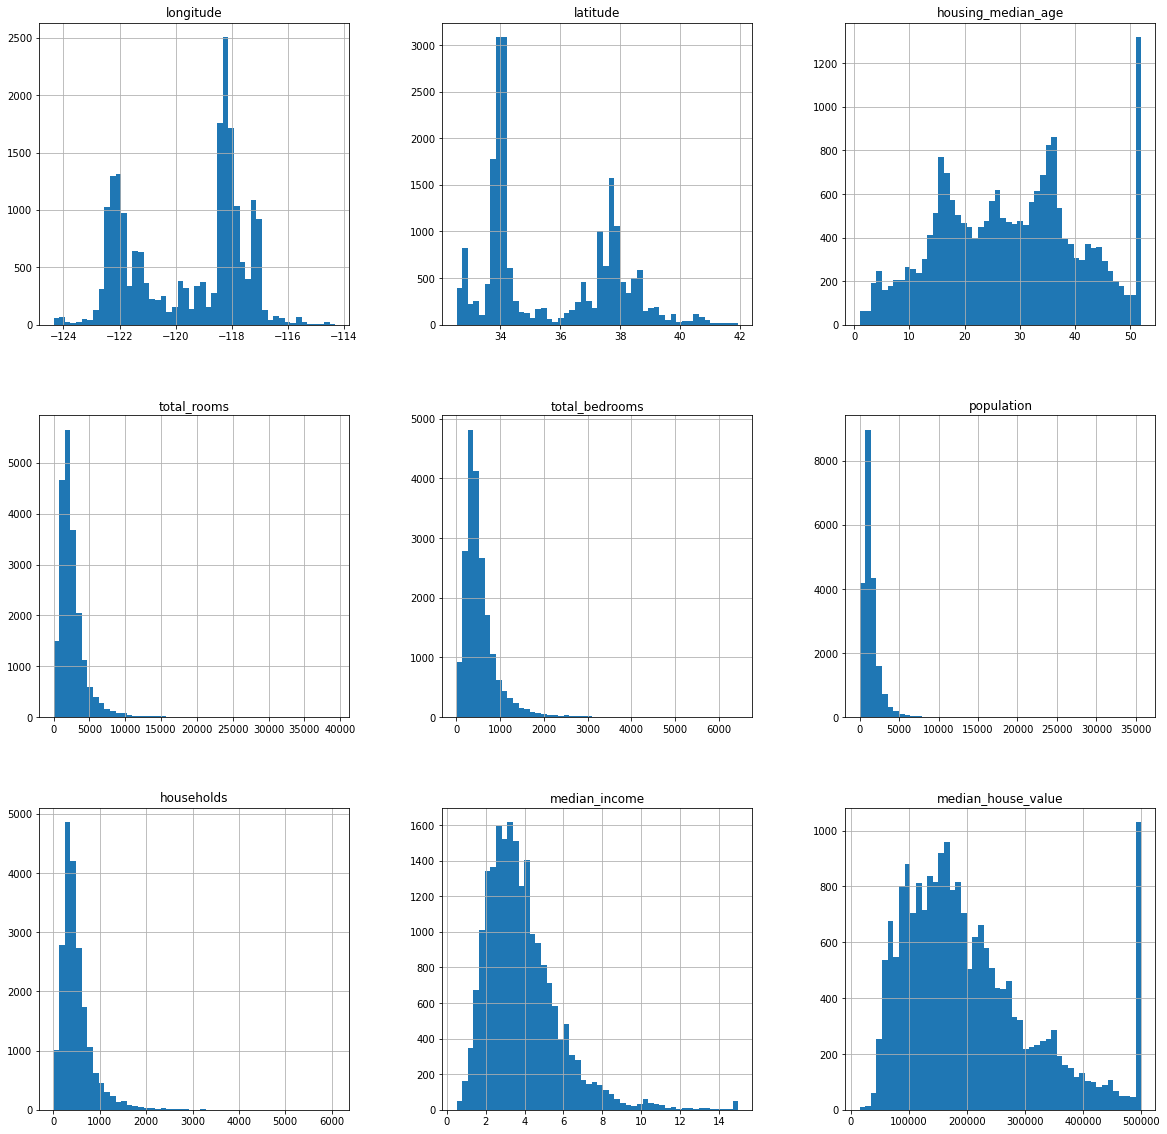

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,20))
plt.show()

## Create train and test set

In [12]:
import numpy as np

def split_data(data, test_radio=0.2):
    np.random.seed(42)
    shuffled_indexes = np.random.permutation(len(data))
    test_len = int(len(data) * test_radio)
    train_indexes = shuffled_indexes[:test_len]
    test_indexes = shuffled_indexes[test_len:]
    return data.iloc[train_indexes], data.iloc[test_indexes]

train, test = split_data(data)

<AxesSubplot:>

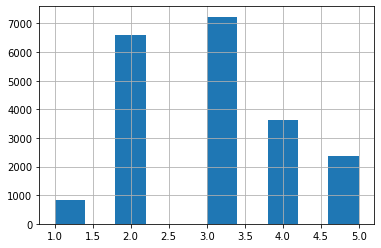

In [13]:
data["income_category"] = pd.cut(data["median_income"], 
                                bins = [0, 1.5, 3, 4.5, 6, np.inf],
                                labels = [1,2,3,4,5])

data["income_category"].hist()

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indexes, test_indexes in split.split(data, data["income_category"]):
    strat_train = data.loc[train_indexes]
    strat_test = data.loc[test_indexes]


In [15]:
strat_test["income_category"].value_counts() / len(strat_test)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_category, dtype: float64

In [16]:
for _set in (strat_train, strat_test):
    _set.drop("income_category", axis=1, inplace=True)

## Explore dataset

In [17]:
data = strat_train.copy()

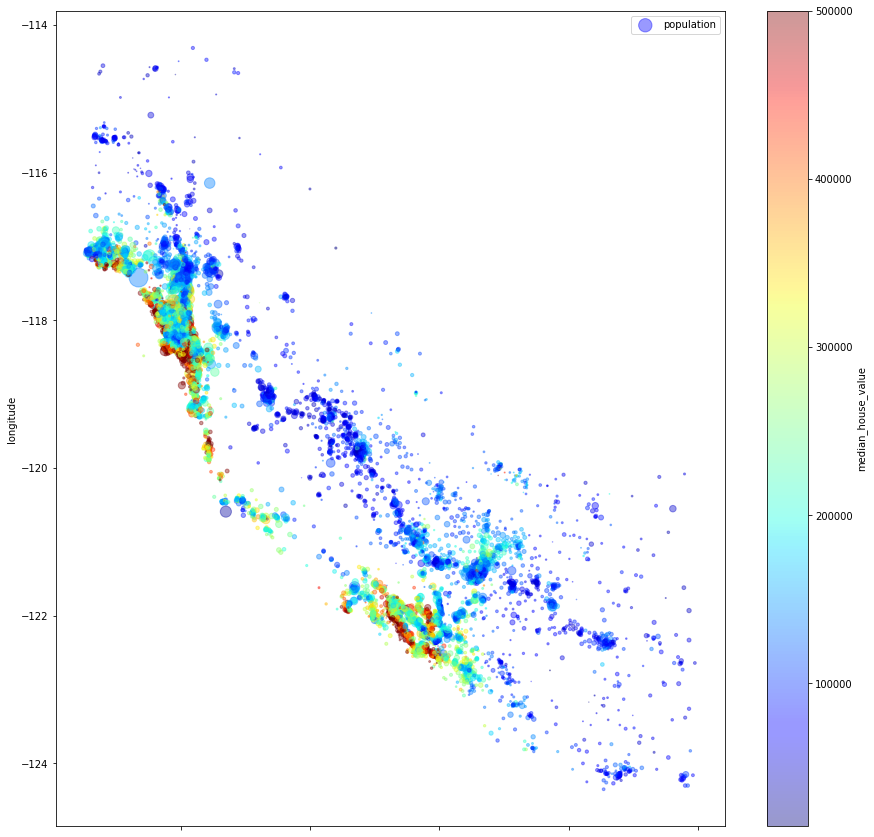

In [18]:
data.plot(kind='scatter', x='latitude', y='longitude', alpha=0.4, figsize=(15,15), label='population',
         s = data["population"] / 100, c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [19]:
corr = data.corr()
corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


array([[<AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='population', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='population', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='population', ylabel='total_

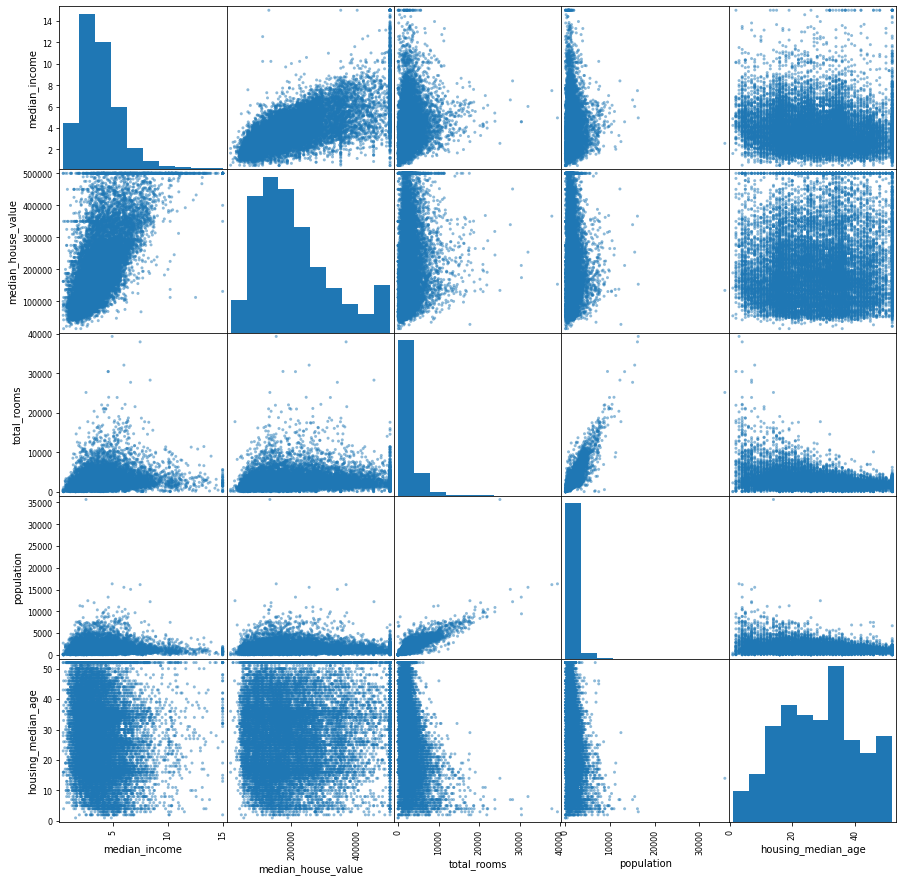

In [20]:
from pandas.plotting import scatter_matrix

attributes = ["median_income", "median_house_value", "total_rooms", "population", "housing_median_age"]
scatter_matrix(data[attributes], figsize=(15,15))

In [21]:
data["rooms_per_household"] = data["total_rooms"] / data["households"]
data["bedroom_ratio"] = data["total_bedrooms"] / data["total_rooms"]

corr = data.corr()
corr["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.687151
rooms_per_household    0.146255
total_rooms            0.135140
housing_median_age     0.114146
households             0.064590
total_bedrooms         0.047781
population            -0.026882
longitude             -0.047466
latitude              -0.142673
bedroom_ratio         -0.259952
Name: median_house_value, dtype: float64

## Prepare data for algorithm

In [22]:
data = strat_train.copy()
values = data.drop("median_house_value", axis=1)
labels = data["median_house_value"].copy()

### Median of total_bedrooms column

In [23]:
median = data["total_bedrooms"].median()
data["total_bedrooms"].fillna(median, inplace=True)

In [24]:
ocean_proximity = data[["ocean_proximity"]]
ocean_proximity.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [25]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
housing_cat_1hot = one_hot_encoder.fit_transform(ocean_proximity)

In [26]:
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(data.values)

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('adder', CombinedAttributesAdder()),
    ('std', StandardScaler())
])

housing_num_tr = pipeline.fit_transform(housing_cat_1hot)

IndexError: column index (6) out of range